# COSC 325 Final Project: Credit Card Fraud Analysis
### By "Regularly Scheduled Programming"
**Will Greenwood**&emsp;**Maddie Gross**&emsp;**Cinzia Pacione**&emsp;**Ethan Weathers**

### Contents

- **Introduction and Getting Started**
    - Import Dependencies
    - Read and Clean Data
    - Metadata Access
    - Useful Lookups
<p>&nbsp;</p>

- **Exploratory Data Analysis**
    - Location Data
        - Total Transactions by State
        - Fraud Index by State
    - Time Data
        - Fraud Cases by Month
        - Fraud Cases by Day of the Week
        - Transactions Per Hour with Fraud Percentage
    - Category Data
        - Transactions Per Purchase Category with Fraud Percentage
        - Most Common Categories of Fraudulent Transactions
    - Monetary Data
        - Relationship Between Purchase Amount and Fraud
        - Distribution of Purchase Amount by Fraud Status
        - Purchase Amounts for Fraud vs Non-Fraud Transactions
    - Age Breakdown
        - Fraud by Age
<p>&nbsp;</p>

- **Machine Learning Analysis**
    - Random Forest Implementation
        - Baseline Model
        - Baseline Analysis
        - Confusion Matrix
        - Precision-Recall Curve
<p>&nbsp;</p>

## Introduction and Getting Started

Intro to this section...

### Import Dependencies

In [7]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy import stats
import seaborn as sns

### Read and Clean Data

Add details later...

In [8]:
# Store csv in a pandas DataFrame
df = pd.read_csv("fraud_data.csv")

# Drop unused columns
drop_columns = []
if drop_columns:
    df.drop(columns=drop_columns, inplace=True)

# Verify there are no null values
null_count = df.isnull().sum()

# Convert selective columns to appropriate data types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'],
                                             format='%d-%m-%Y %H:%M')

# Add useful columns
df['day_of_week'] = df['trans_date_trans_time'].dt.day_of_week
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year

df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')
df['age'] = 2019 - df['dob'].dt.year


Optional cell to write metadata to a file:

In [9]:
show_metadata = False
if show_metadata:
    with open("metadata.txt", "w") as f:
        from io import StringIO
        
        buffer = StringIO()
        df.info(buf=buffer)
        f.write("DataFrame Info:\n")
        f.write(buffer.getvalue())
        
        f.write("\n\nNumber of unique values per column:\n")
        f.write(df.nunique().to_string())
        
        f.write("\n\nNull values per column:\n")
        f.write(null_count.to_string())

And here are some useful additions/lookups...

In [10]:
# Lookup total number of transactions in entire dataset
total_transactions = len(df)

# Separate DataFrame for just the fraudulent transactions
df_fraud = df[df['is_fraud'] == 1]
fraud_count = len(df_fraud)

# Dictionary to replace snake_case labels with regular text
label_map = {
    'grocery_pos':    'Grocery Pos',
    'gas_transport':  'Gas Transport',
    'shopping_net':   'Shopping Net',
    'shopping_pos':   'Shopping Pos',
    'home':           'Home',
    'kids_pets':      'Kids Pets',
    'personal_care':  'Personal Care',
    'entertainment':  'Entertainment',
    'health_fitness': 'Health Fitness',
    'food_dining':    'Food Dining',
    'misc_pos':       'Misc Pos',
    'misc_net':       'Misc Net',
    'grocery_net':    'Grocery Net',
    'travel':         'Travel'
}

## Exploratory Data Analysis

Intro to this section...

### Location Data

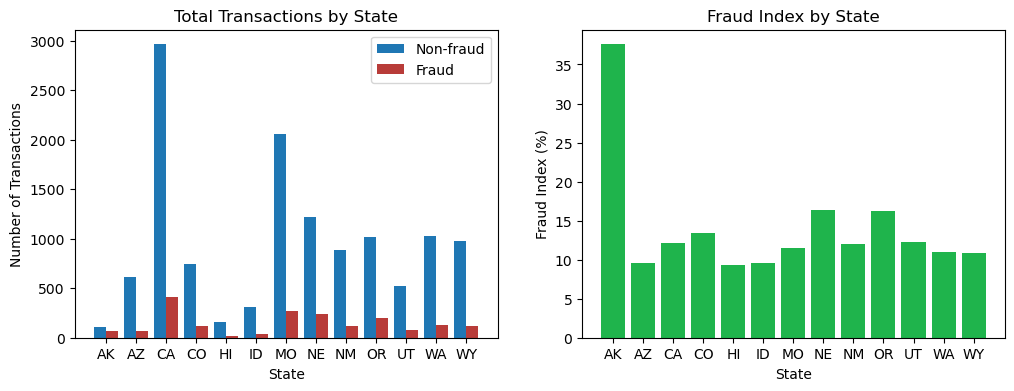

In [11]:
# Get unique states
states = sorted(df['state'].unique())

# Prepare data for total transactions chart
bar_width = 0.4
x = np.arange(len(states))

non_fraud_counts = [df[(df['state'] == state) & (df['is_fraud'] == 0)].shape[0] for state in states]
fraud_counts = [df[(df['state'] == state) & (df['is_fraud'] == 1)].shape[0] for state in states]

# Calculate fraud index
total_state_tr = df['state'].value_counts()
fraud_state_tr = df[df['is_fraud'] == 1]['state'].value_counts()
fraud_index = (fraud_state_tr / total_state_tr * 100).reindex(states, fill_value=0) 

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Total Transactions by State
axes[0].bar(x - (bar_width / 2), non_fraud_counts, bar_width, label="Non-fraud", color='#1f77b4')
axes[0].bar(x + (bar_width / 2), fraud_counts, bar_width, label="Fraud", color='#B83C39')
axes[0].set_xticks(x, states)
axes[0].set_xlabel("State")
axes[0].set_ylabel("Number of Transactions")
axes[0].set_title("Total Transactions by State")
axes[0].legend()

# Fraud Index by State
axes[1].bar(states, fraud_index, color='#1fb44c')
axes[1].set_ylabel('Fraud Index (%)')
axes[1].set_xlabel('State')
axes[1].set_title('Fraud Index by State')

plt.show()


### Time Data

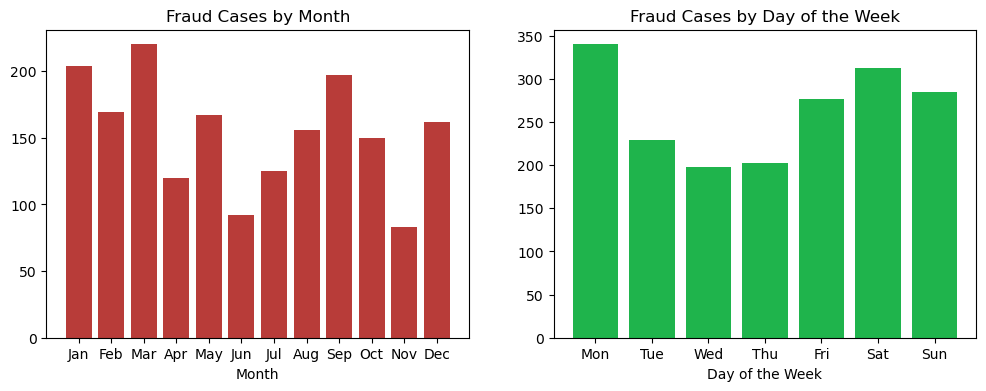

In [12]:
fraud_by_month = df_fraud['month'].value_counts().sort_index()
fraud_by_day = df_fraud['day_of_week'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(fraud_by_month.index, fraud_by_month.values, color='#B83C39')
axes[0].set_title("Fraud Cases by Month")
axes[0].set_xlabel("Month")
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

axes[1].bar(fraud_by_day.index, fraud_by_day.values, color='#1fb44c')
axes[1].set_title("Fraud Cases by Day of the Week")
axes[1].set_xlabel("Day of the Week")
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show()


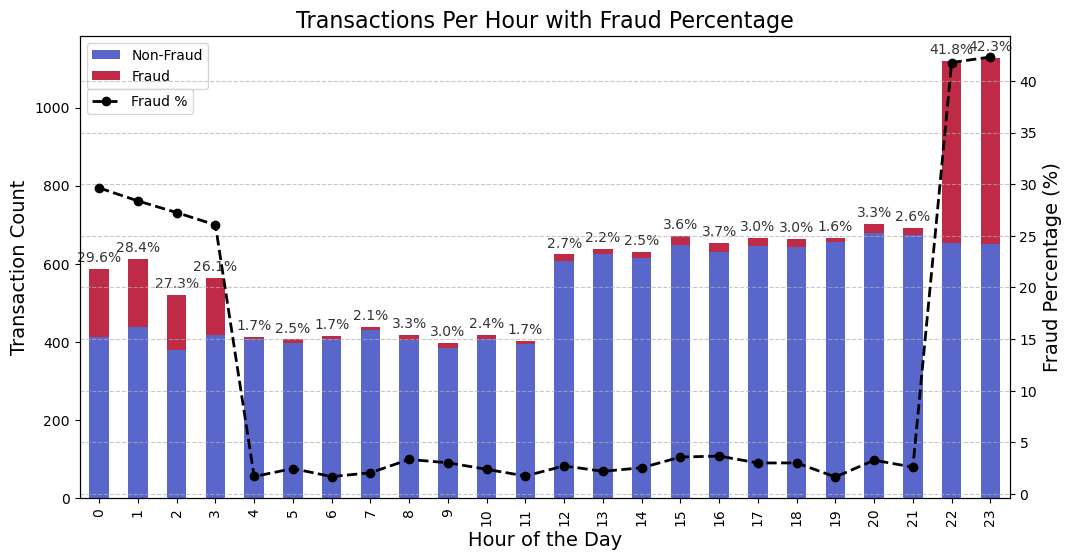

In [13]:
df_time = pd.read_csv("fraud_data.csv", parse_dates=["trans_date_trans_time"])

df_time["trans_date_trans_time"] = pd.to_datetime(df_time["trans_date_trans_time"], format="%d-%m-%Y %H:%M")
df_time["hour"] = df_time["trans_date_trans_time"].dt.hour
hourly_data = df_time.groupby(["hour", "is_fraud"]).size().unstack(fill_value=0)
hourly_data.columns = ["Non-Fraud", "Fraud"]
hourly_data["Fraud %"] = (hourly_data["Fraud"] / (hourly_data["Non-Fraud"] + hourly_data["Fraud"])) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stacked bars
# Stacked bar chart
bars = hourly_data[["Non-Fraud", "Fraud"]].plot(
    kind="bar",
    stacked=True,
    colormap="coolwarm",
    alpha=0.85,
    ax=ax1
)

# Create a second Y-axis for fraud percentage
ax2 = ax1.twinx()
ax2.plot(hourly_data.index, hourly_data["Fraud %"], marker="o", color="black", linestyle="dashed", linewidth=2, label="Fraud %")

# Add fraud percentage labels on top of each bar
for i, (index, row) in enumerate(hourly_data.iterrows()):
    total = row["Non-Fraud"] + row["Fraud"]
    fraud_pct = row["Fraud %"]
    if total > 0:  # Avoid division by zero
        ax1.annotate(f"{fraud_pct:.1f}%", 
                     xy=(i, total),  # Position at top of the stacked bars
                     xytext=(0, 5),  # Offset slightly above
                     textcoords="offset points",
                     ha="center", fontsize=10, color="#333")

# Labels and title
ax1.set_xlabel("Hour of the Day", fontsize=14)
ax1.set_ylabel("Transaction Count", fontsize=14)
ax2.set_ylabel("Fraud Percentage (%)", fontsize=14)
ax1.set_title("Transactions Per Hour with Fraud Percentage", fontsize=16)
ax1.set_xticks(range(24))
ax1.legend(loc="upper left")
ax2.legend(loc="upper left", bbox_to_anchor=(0, .9))  # Position fraud percentage legend below

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### Category Data

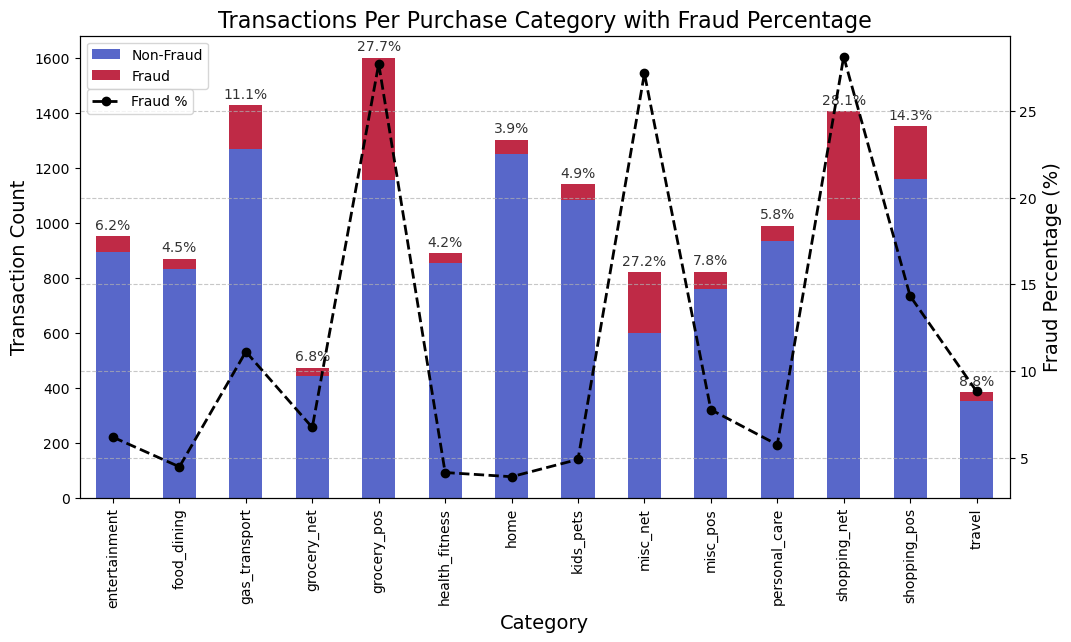

In [17]:
categorical_data = df_time.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)
categorical_data.columns = ['Non-Fraud', 'Fraud']
categorical_data['Fraud %'] = (categorical_data['Fraud'] / (categorical_data['Non-Fraud'] + categorical_data['Fraud'])) * 100

fig1, ax3 = plt.subplots(figsize=(12, 6))

# Plot stacked bars
# Stacked bar chart
bars = categorical_data[["Non-Fraud", "Fraud"]].plot(
    kind="bar",
    stacked=True,
    colormap="coolwarm",
    alpha=0.85,
    ax=ax3
)

# Create a second Y-axis for fraud percentage
ax4 = ax3.twinx()
ax4.plot(categorical_data.index, categorical_data["Fraud %"], marker="o", color="black", linestyle="dashed", linewidth=2, label="Fraud %")

# Add fraud percentage labels on top of each bar
for i, (index, row) in enumerate(categorical_data.iterrows()):
    total = row["Non-Fraud"] + row["Fraud"]
    fraud_pct = row["Fraud %"]
    if total > 0:  # Avoid division by zero
        ax3.annotate(f"{fraud_pct:.1f}%", 
                     xy=(i, total),  # Position at top of the stacked bars
                     xytext=(0, 5),  # Offset slightly above
                     textcoords="offset points",
                     ha="center", fontsize=10, color="#333")

# Labels and title
ax3.set_xlabel("Category", fontsize=14)
ax3.set_ylabel("Transaction Count", fontsize=14)
ax4.set_ylabel("Fraud Percentage (%)", fontsize=14)
ax3.set_title("Transactions Per Purchase Category with Fraud Percentage", fontsize=16)
ax3.set_xticks(range(len(categorical_data)))
ax3.legend(loc="upper left")
ax4.legend(loc="upper left", bbox_to_anchor=(0, .9))  # Position fraud percentage legend below

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

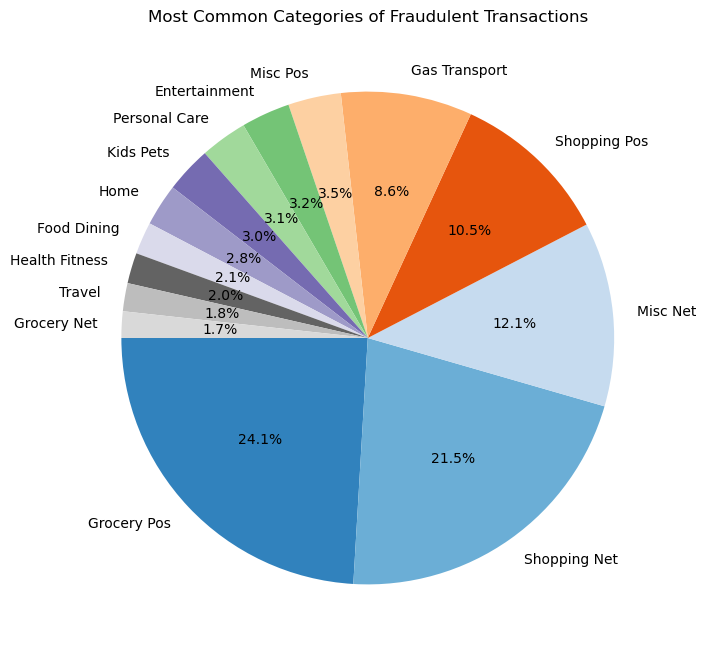

In [18]:
category_counts = df_fraud['category'].value_counts(normalize=True) * 100

# Apply mapping to rename labels
category_counts = category_counts.rename(index=label_map)

plt.figure(figsize=(8, 8))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=180, colormap='tab20c')
plt.ylabel('')  # Hide y-axis label
plt.title('Most Common Categories of Fraudulent Transactions')
plt.show()

### Monetary Data

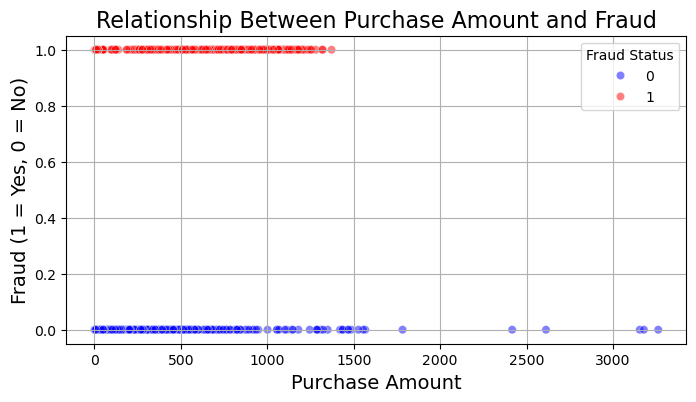

In [146]:
plt.figure(figsize=(8, 4))

# Create a scatter plot with fraud transactions in red and non-fraud in blue
sns.scatterplot(data=df_time, x="amt", y="is_fraud", alpha=0.5, hue="is_fraud", palette={0: "blue", 1: "red"})

plt.xlabel("Purchase Amount", fontsize=14)
plt.ylabel("Fraud (1 = Yes, 0 = No)", fontsize=14)
plt.title("Relationship Between Purchase Amount and Fraud", fontsize=16)
plt.legend(title="Fraud Status")
plt.grid(True)

plt.show()

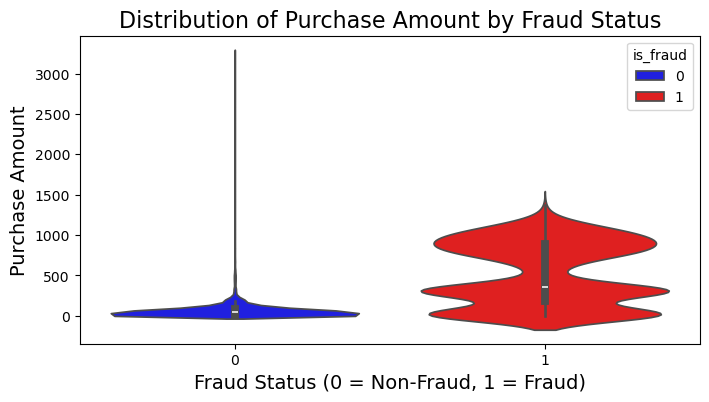

In [19]:
plt.figure(figsize=(8, 4))

sns.violinplot(data=df_time, x="is_fraud", y="amt",hue="is_fraud", palette={0: "blue", 1: "red"})

plt.xlabel("Fraud Status (0 = Non-Fraud, 1 = Fraud)", fontsize=14)
plt.ylabel("Purchase Amount", fontsize=14)
plt.title("Distribution of Purchase Amount by Fraud Status", fontsize=16)

plt.show()

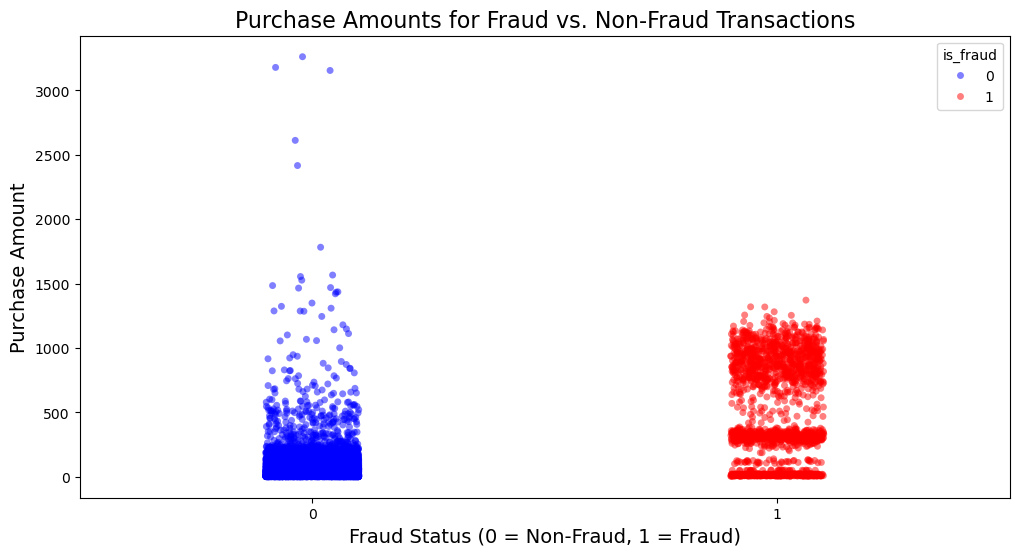

In [20]:
plt.figure(figsize=(8, 4))

sns.stripplot(data=df_time, x="is_fraud", y="amt", hue="is_fraud", jitter=True, alpha=0.5, palette={0: "blue", 1: "red"})

plt.xlabel("Fraud Status (0 = Non-Fraud, 1 = Fraud)", fontsize=14)
plt.ylabel("Purchase Amount", fontsize=14)
plt.title("Purchase Amounts for Fraud vs. Non-Fraud Transactions", fontsize=16)

plt.show()

### Age Breakdown

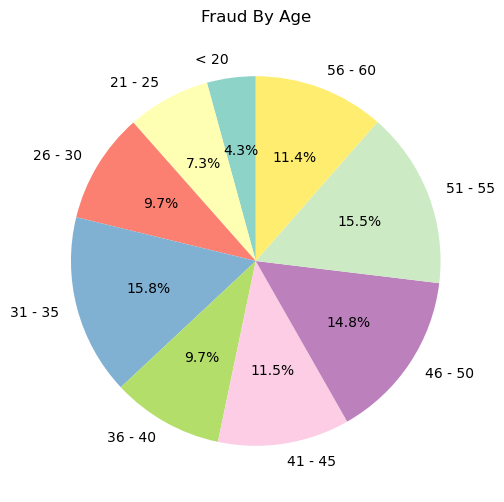

In [149]:
age_brackets = ['< 20',
                '21 - 25', '26 - 30',
                '31 - 35', '36 - 40',
                '41 - 45', '46 - 50',
                '51 - 55', '56 - 60']
age_ranges = [(0, 20),
              (21, 25), (26, 30),
              (31, 35), (36, 40),
              (41, 45), (46, 50),
              (51, 55), (56, 60)]

age_bracket_counts = {}
for bracket, (low, high) in zip(age_brackets, age_ranges):
    age_bracket_counts[bracket] = ((df_fraud['age'] >= low) & (df_fraud['age'] <= high)).sum()

age_fraud_percentage = {
    'Age Bracket': age_bracket_counts.keys(),
    'Percentage': [(count / fraud_count) * 100 for count in age_bracket_counts.values()]
}

age_percentage_df = pd.DataFrame(age_fraud_percentage)

# Plot pie chart
plt.figure(figsize=(6, 6))
age_percentage_df.set_index('Age Bracket')['Percentage'].plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Set3')
plt.ylabel('')
plt.title('Fraud By Age')
plt.show()

## Machine Learning

Intro to this section...

### Baseline Random Forest Implementation by *Robin Rawat*

Intro to this section...

blah blah...using [Rawat's random forest implementation](https://www.kaggle.com/code/robinsinghrawat/credit-card-fraud-analysis).

In [21]:
# random forest baseline model
df_rand_forest = df.copy()

# Adding useful columns
df_rand_forest['trans_date_trans_time'] = pd.to_datetime(df_rand_forest['trans_date_trans_time'], format='%d-%m-%Y %H:%M')

#Extracting hour of transaction
df_rand_forest['transaction_hour'] = df_rand_forest['trans_date_trans_time'].dt.hour

#Dropping irrelevant columns
df_rand_forest = df_rand_forest.drop(columns=
                                     ['trans_date_trans_time',
                                      'dob',
                                      'trans_num',
                                      'merchant',
                                      'state',
                                      'city'])

#Choosing categorical columns to fit into model training
categorical_columns = ['category', 'job']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_rand_forest[col] = le.fit_transform(df_rand_forest[col])
    label_encoders[col] = le

#Converting target variable to numeric
df_rand_forest['is_fraud'] = df_rand_forest['is_fraud'].astype(int)

#Features and target
X = df_rand_forest.drop(columns=['is_fraud'])
y = df_rand_forest['is_fraud']

#Splitting the data 80:20 for training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#Standardizing features using Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Initializing the model
rf = RandomForestClassifier(random_state=7)

#Setting up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

#Fitting the grid search to the data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

Analysis:

In [153]:
#Output of the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

best_params = grid_search.best_params_
final_rf = RandomForestClassifier(**best_params, random_state=7)
final_rf.fit(X_train, y_train)

y_pred = final_rf.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.9965386694296422


,precision,recall,f1-score,support
0,0.997644,1.000000,0.998821,2541.000000
1,1.000000,0.982808,0.991329,349.000000
accuracy,0.997924,0.997924,0.997924,0.997924
macro avg,0.998822,0.991404,0.995075,2890.000000
weighted avg,0.997929,0.997924,0.997916,2890.000000


Confusion matrix using optimal hyperparameters...

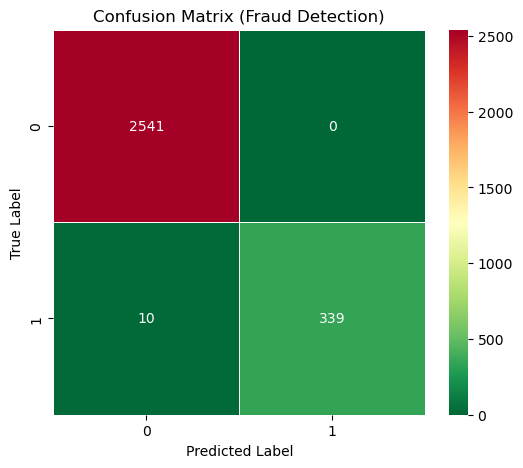

In [151]:
# confusion matrix
threshold = .5 #Usual threshhold number

predicted_classes_test = (y_pred >= threshold).astype(int)

cm_test = confusion_matrix(y_test, predicted_classes_test)

# Create a heatmap with a custom color gradient
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="RdYlGn_r", linewidths=0.5, cbar=True)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fraud Detection)")
plt.show()

Precision-Recall Curve

In [23]:
# precision-recall curve

Conclusions:
- trees